In [1]:
# !pip install numpy==1.19.5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

c:\users\gamepc\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\gamepc\miniconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\gamepc\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [28]:
with open ('data_kia.csv', 'r') as f:
    l = f.readline()
    i = l.split(",")
    
    for n, v in enumerate(i):
        print(f"{n}: {v}")

0: Fuel_consumption
1: Accelerator_Pedal_value
2: Throttle_position_signal
3: Short_Term_Fuel_Trim_Bank1
4: Intake_air_pressure
5: Filtered_Accelerator_Pedal_value
6: Absolute_throttle_position
7: Engine_soacking_time
8: Inhibition_of_engine_fuel_cut_off
9: Engine_in_fuel_cut_off
10: Fuel_Pressure
11: Long_Term_Fuel_Trim_Bank1
12: Engine_speed
13: Engine_torque_after_correction
14: Torque_of_friction
15: Flywheel_torque_(after_torque_interventions)
16: Current_spark_timing
17: Engine_coolant_temperature
18: Engine_Idel_Target_Speed
19: Engine_torque
20: Calculated_LOAD_value
21: Minimum_indicated_engine_torque
22: Maximum_indicated_engine_torque
23: Flywheel_torque
24: Torque_scaling_factor(standardization)
25: Standard_Torque_Ratio
26: Requested_spark_retard_angle_from_TCU
27: TCU_requests_engine_torque_limit_(ETL)
28: TCU_requested_engine_RPM_increase
29: Target_engine_speed_used_in_lock-up_module
30: Glow_plug_control_request
31: Activation_of_Air_compressor
32: Torque_converter_spe

In [2]:
def import_data():
    """
    Import data and split into features and labels
    """
    data = pd.read_csv('data_kia.csv').values
    x_data = data[:, :51]
    y_data = data[:, 52]
    return x_data, y_data

data, labels = import_data()
data

array([[268.8, 0.0, 5.2, ..., -8.8, 0, -3.4],
       [243.2, 0.0, 6.1, ..., -0.2, 0, -3.6],
       [217.6, 0.0, 5.2, ..., -0.2, 0, -3.6],
       ...,
       [345.6, 0.0, 6.6, ..., 0.0, 0, -13.2],
       [332.8, 0.0, 5.7, ..., 0.0, 0, -13.3],
       [281.6, 0.0, 5.2, ..., -0.1, 0, -13.3]], dtype=object)

In [3]:
scaler = preprocessing.MinMaxScaler().fit(data)

In [4]:
def normalize_data(rows, max_columns=None, min_columns=None):
    try:
        if max_columns == None:
            max_columns = rows.max(axis=0)
    except:
        pass
    
    try:
        if min_columns == None:
            min_columns = rows.min(axis=0)
    except:
        pass
    norm_rows = np.empty(rows.shape)
    for i in range(rows.shape[1]):
        for j in range(rows.shape[0]):
            if ((max_columns[i]-min_columns[i])>0):
                norm_rows[j][i] = (rows[j][i] - min_columns[i])/(max_columns[i]-min_columns[i])
            else:
                norm_rows[j][i] = 0
    return norm_rows, max_columns, min_columns

normal_data, max_columns, min_columns = normalize_data(data)
normal_data


array([[0.02459016, 0.        , 0.052     , ..., 0.07650273, 0.        ,
        0.49030656],
       [0.02224824, 0.        , 0.061     , ..., 0.54644809, 0.        ,
        0.49011556],
       [0.01990632, 0.        , 0.052     , ..., 0.54644809, 0.        ,
        0.49011556],
       ...,
       [0.03161593, 0.        , 0.066     , ..., 0.55737705, 0.        ,
        0.48094738],
       [0.03044496, 0.        , 0.057     , ..., 0.55737705, 0.        ,
        0.48085188],
       [0.02576112, 0.        , 0.052     , ..., 0.55191257, 0.        ,
        0.48085188]])

In [62]:
def onehot_labels(labels, num_labels=10, skip=8):
    """
    Converts label array to 1-hot encoded vectors
    """

    result = []

    for l in labels:
        label_vector = [0] * num_labels
        index = ord(l) - ord('A')
        label_vector[index] = 1

        result.append(label_vector)

    return np.array([result[i] for i in range(0, len(result) - 16, skip)])

# y_data = tf.convert_to_tensor(onehot_labels(labels), dtype=tf.float64)
y_data = onehot_labels(labels)
len(y_data)

11796

In [58]:
def package_data(data, window_size=16):
    result = []
    for i in range(0, len(data) - window_size, window_size // 2):
        result.append((data[i:i + window_size]))

    return (result)
# x_data = tf.convert_to_tensor(package_data(normal_data), dtype=tf.float64)
x_data = package_data(normal_data)
len(x_data)

11796

In [59]:

def add_noise(data, noise_level, std_level):
    noise_map = np.random.rand(data.shape[0], data.shape[1])

    non_noise_indices = np.where(noise_map > noise_level)
    
    noise = np.random.normal(0, std_level, data.shape)
    noise[non_noise_indices] = 0

    return data + noise

noisy_data = add_noise(data, 0.8, 2.0)
noisy_data 
    


array([[269.17754954178076, -0.25398310581042066, 5.412048993118428, ...,
        -8.8, 0.0, -3.4],
       [245.75884731578657, 0.0, 5.769502371747623, ...,
        2.242361221829895, 0.0, -3.965980820785128],
       [218.22892417606406, -1.5479556664474132, 9.134596489543483, ...,
        -3.7250379422967552, 1.067173191496098, -3.028270526228102],
       ...,
       [342.78954351410556, -2.349307517681499, 4.170284545476065, ...,
        -1.3969499799733904, 4.699858827032949, -13.536335538100017],
       [330.85528705209975, 0.4023176422577752, 5.79192565340289, ...,
        1.4988125650487314, 2.8866548609734806, -11.499207916735598],
       [282.41589242656795, 0.29586407711788243, 5.2, ...,
        -1.5199822962770408, 2.70799943705246, -12.71769380862402]],
      dtype=object)

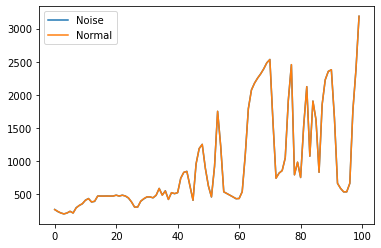

In [35]:
plt.plot(noisy_data[:100, 0])
plt.plot(data[:100, 0])
plt.legend(["Noise", "Normal"])
plt.show()

In [68]:
data_sets = []
std_levels = [0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]
for i in std_levels:
    data_sets.append(normalize_data(add_noise(data, 1, i), max_columns=max_columns, min_columns=min_columns)[0])

In [69]:
packaged_data = []
for data_set in data_sets:
    packaged_data.append(np.array(package_data(data_set)))

In [65]:
# create train and test batches
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data[:], test_size=0.15
)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape), print(x_test.shape)
print(y_train.shape, y_test.shape)

(10026, 16, 51)
(1770, 16, 51)
(10026, 10) (1770, 10)


In [70]:
def create_model(learning_rate=1e-4, window_size=16, num_features=51):
    model = Sequential()
    model.add(LSTM(160, input_shape=(window_size, num_features), return_sequences=True ))
    model.add(LSTM(200, ))

    model.add(Dense(10, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['categorical_crossentropy'])

    return model

In [71]:
model = create_model()
model.fit(x_train, y_train, epochs=250, batch_size=128, validation_split=0.05)

Epoch 1/250
75/75 [==============================] - 1s 15ms/step - loss: 2.2542 - categorical_crossentropy: 2.2542 - val_loss: 2.1639 - val_categorical_crossentropy: 2.1639
Epoch 2/250
75/75 [==============================] - 0s 6ms/step - loss: 1.9801 - categorical_crossentropy: 1.9801 - val_loss: 1.7806 - val_categorical_crossentropy: 1.7806
Epoch 3/250
75/75 [==============================] - 0s 6ms/step - loss: 1.6071 - categorical_crossentropy: 1.6071 - val_loss: 1.5414 - val_categorical_crossentropy: 1.5414
Epoch 4/250
75/75 [==============================] - 0s 6ms/step - loss: 1.4039 - categorical_crossentropy: 1.4039 - val_loss: 1.3757 - val_categorical_crossentropy: 1.3757
Epoch 5/250
75/75 [==============================] - 0s 6ms/step - loss: 1.2856 - categorical_crossentropy: 1.2856 - val_loss: 1.2616 - val_categorical_crossentropy: 1.2616
Epoch 6/250
75/75 [==============================] - 0s 6ms/step - loss: 1.1824 - categorical_crossentropy: 1.1824 - val_loss: 1.1863 

75/75 [==============================] - 0s 6ms/step - loss: 0.4775 - categorical_crossentropy: 0.4775 - val_loss: 0.4557 - val_categorical_crossentropy: 0.4557
Epoch 49/250
75/75 [==============================] - 0s 6ms/step - loss: 0.4497 - categorical_crossentropy: 0.4497 - val_loss: 0.4706 - val_categorical_crossentropy: 0.4706
Epoch 50/250
75/75 [==============================] - 0s 6ms/step - loss: 0.4387 - categorical_crossentropy: 0.4387 - val_loss: 0.4220 - val_categorical_crossentropy: 0.4220
Epoch 51/250
75/75 [==============================] - 0s 6ms/step - loss: 0.4130 - categorical_crossentropy: 0.4130 - val_loss: 0.4740 - val_categorical_crossentropy: 0.4740
Epoch 52/250
75/75 [==============================] - 0s 6ms/step - loss: 0.4240 - categorical_crossentropy: 0.4240 - val_loss: 0.4439 - val_categorical_crossentropy: 0.4439
Epoch 53/250
75/75 [==============================] - 0s 6ms/step - loss: 0.4284 - categorical_crossentropy: 0.4284 - val_loss: 0.4860 - val_ca

75/75 [==============================] - 1s 7ms/step - loss: 0.2468 - categorical_crossentropy: 0.2468 - val_loss: 0.3104 - val_categorical_crossentropy: 0.3104
Epoch 96/250
75/75 [==============================] - 1s 7ms/step - loss: 0.2477 - categorical_crossentropy: 0.2477 - val_loss: 0.3140 - val_categorical_crossentropy: 0.3140
Epoch 97/250
75/75 [==============================] - 0s 6ms/step - loss: 0.2476 - categorical_crossentropy: 0.2476 - val_loss: 0.3141 - val_categorical_crossentropy: 0.3141
Epoch 98/250
75/75 [==============================] - 1s 7ms/step - loss: 0.2374 - categorical_crossentropy: 0.2374 - val_loss: 0.3164 - val_categorical_crossentropy: 0.3164
Epoch 99/250
75/75 [==============================] - 0s 6ms/step - loss: 0.2446 - categorical_crossentropy: 0.2446 - val_loss: 0.2782 - val_categorical_crossentropy: 0.2782
Epoch 100/250
75/75 [==============================] - 0s 6ms/step - loss: 0.2371 - categorical_crossentropy: 0.2371 - val_loss: 0.2666 - val_c

Epoch 142/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1564 - categorical_crossentropy: 0.1564 - val_loss: 0.2583 - val_categorical_crossentropy: 0.2583
Epoch 143/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1497 - categorical_crossentropy: 0.1497 - val_loss: 0.2106 - val_categorical_crossentropy: 0.2106
Epoch 144/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1295 - categorical_crossentropy: 0.1295 - val_loss: 0.2154 - val_categorical_crossentropy: 0.2154
Epoch 145/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1353 - categorical_crossentropy: 0.1353 - val_loss: 0.2029 - val_categorical_crossentropy: 0.2029
Epoch 146/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1282 - categorical_crossentropy: 0.1282 - val_loss: 0.2082 - val_categorical_crossentropy: 0.2082
Epoch 147/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1210 - categorical_crossentropy: 0.1210 - val_lo

Epoch 189/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0855 - categorical_crossentropy: 0.0855 - val_loss: 0.1865 - val_categorical_crossentropy: 0.1865
Epoch 190/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0668 - categorical_crossentropy: 0.0668 - val_loss: 0.1757 - val_categorical_crossentropy: 0.1757
Epoch 191/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0784 - categorical_crossentropy: 0.0784 - val_loss: 0.3772 - val_categorical_crossentropy: 0.3772
Epoch 192/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1156 - categorical_crossentropy: 0.1156 - val_loss: 0.2296 - val_categorical_crossentropy: 0.2296
Epoch 193/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0963 - categorical_crossentropy: 0.0963 - val_loss: 0.3242 - val_categorical_crossentropy: 0.3242
Epoch 194/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1088 - categorical_crossentropy: 0.1088 - val_lo

Epoch 236/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0457 - categorical_crossentropy: 0.0457 - val_loss: 0.1673 - val_categorical_crossentropy: 0.1673
Epoch 237/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0470 - categorical_crossentropy: 0.0470 - val_loss: 0.1837 - val_categorical_crossentropy: 0.1837
Epoch 238/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0440 - categorical_crossentropy: 0.0440 - val_loss: 0.1779 - val_categorical_crossentropy: 0.1779
Epoch 239/250
75/75 [==============================] - 0s 6ms/step - loss: 0.1184 - categorical_crossentropy: 0.1184 - val_loss: 0.1927 - val_categorical_crossentropy: 0.1927
Epoch 240/250
75/75 [==============================] - 0s 6ms/step - loss: 0.0536 - categorical_crossentropy: 0.0536 - val_loss: 0.1658 - val_categorical_crossentropy: 0.1658
Epoch 241/250
75/75 [==============================] - 0s 7ms/step - loss: 0.0481 - categorical_crossentropy: 0.0481 - val_lo

In [72]:
# noisy_test = add_noise(x_test)
predictions = []
for i, p in enumerate(packaged_data):
    print(i)
    predictions.append(model.predict(p[:25000]))


0
1
2
3
4
5
6
7
8
9


In [73]:
percentages = []

for j, prediction in enumerate(predictions):
    correct_count = 0

    for i, p in enumerate(prediction):
        # check if predicted labels is the same as test label
        if np.argmax(p) == np.argmax(y_data[i]):
            correct_count += 1
    
    percentages.append(correct_count/len(prediction))
# print(f"Accuracy: {correct_count} / {len(prediction)} = {correct_count / len(prediction) * 100:.2f}%")

percentages

[0.9836385215327229,
 0.9681247880637505,
 0.9200576466598847,
 0.7453374025093252,
 0.619362495761275,
 0.525178026449644,
 0.4933875890132248,
 0.4571041030857918,
 0.42878942014242116,
 0.2882332994235334]

[0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]


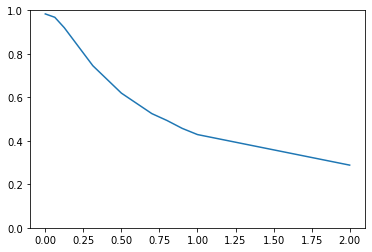

In [75]:
print(std_levels)
plt.plot(std_levels, percentages)
plt.ylim((0.0, 1.0))
plt.show()

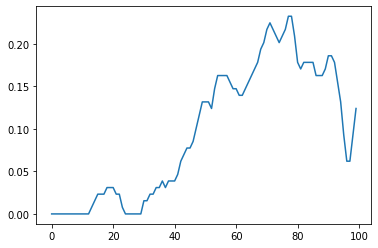

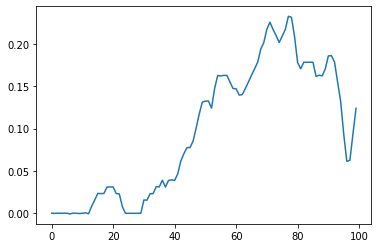

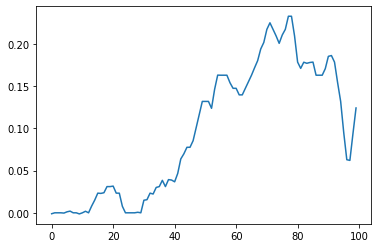

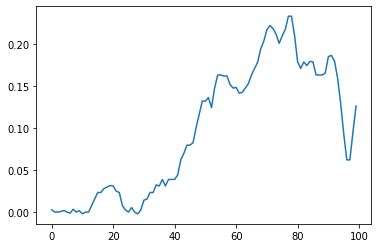

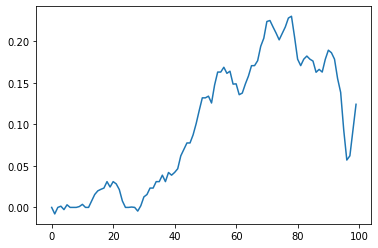

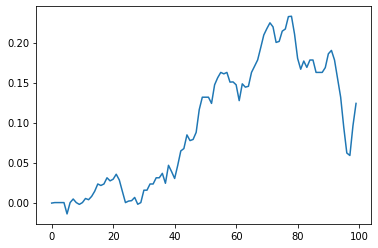

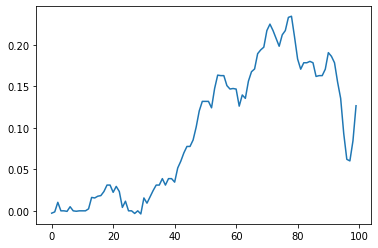

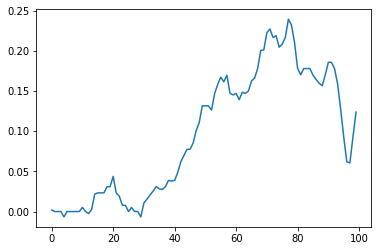

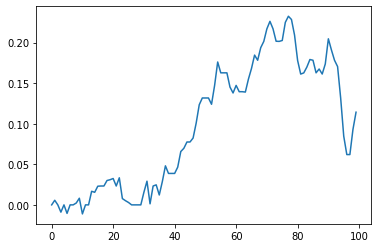

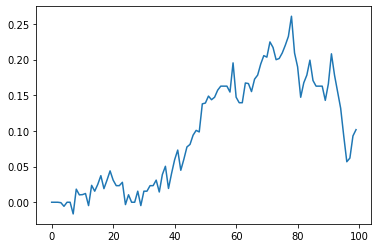

In [24]:
for d in data_sets:
    plt.plot(d[:100, 43])
    plt.show()

In [17]:
model.save("99accuracy.h5")